In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

import torch, config
import IPDL
from autoencoder import SDAE, SDAE_TYPE, AE_CONV_UPSAMPLING
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dropout Effect in Convolutional Layers

In [3]:
from torch import nn

activation_func = [[nn.ReLU(), nn.Identity()], nn.ReLU(), nn.ReLU()]
ae_dropout_p5 = {'dims': [1, 6, 8, 16],
                'sdae_type': SDAE_TYPE.conv,
                'activation_func': activation_func,
                'dropout': True,
                'p': .5,
                'skip_connection': False,
                'upsample': AE_CONV_UPSAMPLING.up_layer}

ae_dropout_p2 = {'dims': [1, 6, 8, 16],
                'sdae_type': SDAE_TYPE.conv,
                'activation_func': activation_func,
                'dropout': True,
                'p': .2,
                'skip_connection': False,
                'upsample': AE_CONV_UPSAMPLING.up_layer}

ae_no_dropout = {'dims': [1, 6, 8, 16],
                'sdae_type': SDAE_TYPE.conv,
                'activation_func': activation_func,
                'dropout': False,
                'skip_connection': False,
                'upsample': AE_CONV_UPSAMPLING.up_layer}

In [4]:
from torch import nn
# model_name = 'ae_dropout_p5'
# model = SDAE(**ae_dropout_p5)

model_name = 'ae_dropout_p2'
model = SDAE(**ae_dropout_p2)

# model_name = 'ae_no_dropout'
# model = SDAE(**ae_no_dropout)

model

SDAE(
  (encode): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (3): ReLU()
      (4): Dropout2d(p=0.2, inplace=False)
      (5): MatrixEstimator(sigma=0.10, requires_optim=True)
    )
    (1): Sequential(
      (0): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (3): ReLU()
      (4): Dropout2d(p=0.2, inplace=False)
      (5): MatrixEstimator(sigma=0.10, requires_optim=True)
    )
    (2): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil

In [5]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose, Normalize

transforms = Compose([
    Resize((64,64)),
    ToTensor(),
    Normalize([0.5], [0.5])
])

train_set = datasets.FashionMNIST("dataset", train=True, download=True, transform=transforms)
test_set = datasets.FashionMNIST("dataset", train=False, download=True, transform=transforms)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [6]:
from functools import reduce
from IPDL.optim.func import silverman_optimize
from IPDL.functional import matrix_estimator
def get_Ax(x, gamma=.5):
    n = x.size(0)
    d = x.size(1) if len(x.shape)==2 else reduce(lambda x,y:x*y, x.shape[1:])

    sigma = silverman_optimize(x, gamma=gamma, normalize=True)
    print(sigma)
    _, Ax = matrix_estimator(x, sigma)
    return Ax

In [7]:
val_inputs = next(iter(test_loader))[0].to(device)
gamma = 4e-1
Ax = get_Ax(val_inputs, gamma=gamma)

25.569722315573685


In [8]:
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as MRE

print("Input Entropy: {}".format(MRE.entropy(Ax)))

Input Entropy: 5.212737083435059


In [9]:
from IPDL.optim import SilvermanOptimizer
from torch.utils.tensorboard import SummaryWriter

from utils import TBLog

tb_writer = SummaryWriter('logs/{}/AE_FMNIST'.format(model_name))
tb_log = TBLog(model, tb_writer)

In [10]:
from torch import nn, tensor, zeros
from torch.nn.init import normal_

class WhiteNoise(nn.Module):
    ''' 
        Pre-imputation 
        
        Apply white noise defined by a Gaussian distribution
    '''
    def __init__(self):
        super(WhiteNoise, self).__init__()
    
    def forward(self, x):
        if self.training:
            noise = normal_(zeros(x.shape), 0, .1)
            noise = noise.to(x.get_device()) if x.get_device() != -1 else noise

            noisy_output = x.detach().clone() + noise
            # noisy_output = ((noisy_output - noisy_output.min()) / noisy_output.max())
            return torch.nn.functional.hardtanh(noisy_output, -1, 1)
        
        return x
    
noise = WhiteNoise()

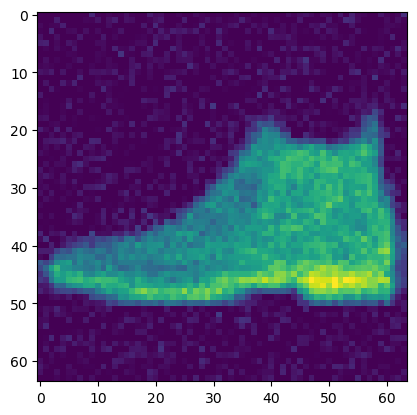

In [11]:
test = noise(val_inputs)

from matplotlib import pyplot as plt
plt.imshow(test[0,0].cpu().detach().numpy())

In [12]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim import Adam
from IPDL.InformationPlane import AutoEncoderInformationPlane
from tqdm import tqdm

from torch import tanh

# gamma=8e-2
n_epoch = 50

# Optimizer
optimizer = Adam(model.parameters(), lr=5e-4)
# optimizer = Adam(model.parameters(), lr=1e-4) # no dropout
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.999)

# IPDL
#   Optimizer
matrix_optimizer = SilvermanOptimizer(model, gamma=gamma, normalize_dim=True)
#   InformationPlane
ip = AutoEncoderInformationPlane(model)

criterion = torch.nn.MSELoss()
model = model.to(device)

epoch_iterator = tqdm(
    range(n_epoch),
    leave=True,
    unit="epoch",
    postfix={"model": model_name,  "tls": "%.4f" % 1, "vls": "%.4f" % 1,},
)

for epoch in epoch_iterator:
    # IP, MI
    model.eval()
    model(val_inputs)

    if epoch == 0: # Solo necesario una vez
        matrix_optimizer.step()
    
    Ixt, Ity = ip.computeMutualInformation(Ax)
    MI = { 'MutualInformation/I(X,T)': {},
           'MutualInformation/I(T,Y)': {}  }
    for idx in range(len(Ixt)):
        scalar_name = 'CL{}'.format(idx)
        MI['MutualInformation/I(X,T)'][scalar_name] = Ixt[idx]
        MI['MutualInformation/I(T,Y)'][scalar_name] = Ity[idx]

    # tb_log.log(MI, epoch-1, include_conv=True, transform=inv_normalize)
    tb_log.log(MI, epoch-1, include_conv=True)

    # Train
    model.train()
    loss_tr = []
    for step, (input, _) in enumerate(train_loader):
        input = input.to(device)
        input_clean = input.detach().clone()
        # if np.random.binomial(1, p=0.2):
        #     input = noise(input)
        output = tanh(model(input))
        batch_loss = criterion(output, input_clean)
        loss_tr.append(batch_loss.detach().item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    with torch.no_grad():
        # Validation
        model.eval()
        loss_ts = []
        for step, (input, _) in enumerate(test_loader):
            input = input.to(device)
            output = tanh(model(input))
            batch_loss = criterion(output, input)
            loss_ts.append(batch_loss.detach().cpu().numpy())

        # scheduler.step()

        epoch_iterator.set_postfix(
            model=model_name, tls="%.4f" % np.mean(loss_tr), vls="%.4f" % np.mean(loss_ts),
        )

    scalars = { 'Loss': {'Train' : np.mean(loss_tr), 'Test': np.mean(loss_ts)},
            'Learning Rate': scheduler.get_last_lr()[0]}
    
    inputs = val_inputs[:4] 
    outputs = tanh(model(inputs))
    # remove normalization
    outputs = (outputs * 0.5) + 0.5
    inputs = (inputs * 0.5) + 0.5
    tb_log.log(scalars, epoch, include_conv=False, input=inputs.reshape((4,1,64,64)), output=outputs.reshape((4,1,64,64)))

100%|██████████| 50/50 [12:22<00:00, 14.85s/epoch, model=ae_dropout_p2, tls=0.1442, vls=0.1140]


In [13]:
model

SDAE(
  (encode): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (3): ReLU()
      (4): Dropout2d(p=0.2, inplace=False)
      (5): MatrixEstimator(sigma=31.33, requires_optim=True)
    )
    (1): Sequential(
      (0): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (3): ReLU()
      (4): Dropout2d(p=0.2, inplace=False)
      (5): MatrixEstimator(sigma=18.06, requires_optim=True)
    )
    (2): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ce

In [14]:
# from pandas import DataFrame, MultiIndex

# def to_df(ip):
#     Ixt = np.array(ip.Ixt)
#     Ity = np.array(ip.Ity)
#     index_names = [
#             list(map(lambda x: 'Layer {}'.format(x), np.repeat(np.arange(len(Ixt)), 2)+1 )),
#             ['Ixt', 'Ity']*len(Ixt)
#         ]
    
#     tuples = list(zip(*index_names))
#     index = MultiIndex.from_tuples(tuples)
#     MI = np.zeros((Ixt.shape[1], Ixt.shape[0]*2), dtype=float)
#     MI[:, 0::2] = Ixt.T
#     MI[:, 1::2] = Ity.T

#     return DataFrame(MI, columns=index)

df = ip.to_df()
# Saving the dataframe with support to MultiIndex
df.to_pickle('data/{}_FMNIST.pkl'.format(model_name))


In [15]:
# Save model
torch.save(model.state_dict(), 'models/{}/AE_FMNIST.pt'.format(model_name))

# Diabetic Foot Ulcer

In [4]:
from torch import nn

activation_func = [[nn.ReLU(), nn.Identity()], nn.ReLU(), nn.ReLU()]
ae_dropout_p5 = {'dims': [1, 6, 8, 16],
                'sdae_type': SDAE_TYPE.conv,
                'activation_func': activation_func,
                'dropout': True,
                'p': .5,
                'skip_connection': False,
                'upsample': AE_CONV_UPSAMPLING.up_layer}

ae_dropout_p2 = {'dims': [1, 6, 8, 16],
                'sdae_type': SDAE_TYPE.conv,
                'activation_func': activation_func,
                'dropout': True,
                'p': .2,
                'skip_connection': False,
                'upsample': AE_CONV_UPSAMPLING.up_layer}

ae_no_dropout = {'dims': [1, 6, 8, 16],
                'sdae_type': SDAE_TYPE.conv,
                'activation_func': activation_func,
                'dropout': False,
                'skip_connection': False,
                'upsample': AE_CONV_UPSAMPLING.up_layer}

In [15]:
# model_name='ae_dropout_p5'
# model = SDAE(**ae_dropout_p5)

# model_name='ae_dropout_p2'
# model = SDAE(**ae_dropout_p2)

model_name='ae_no_dropout'
model = SDAE(**ae_no_dropout)

model.load_state_dict(torch.load('models/{}/AE_FMNIST.pt'.format(model_name)))

<All keys matched successfully>

## Dataset

In [16]:
from DFU import DiabeticFootDataset
# Diabetic Foot Dataset
    # Training dataset
DATASET_DIR = "/home/abian/Data/Dataset/GTMA/DiabeticFootDataset/"
iactec_dataset_dir = os.path.join(DATASET_DIR, 'IACTEC/Processed/Cropped')
inaoe_dataset_dir = os.path.join(DATASET_DIR, 'INAOE/Processed/Cropped')
_dataset = DiabeticFootDataset([iactec_dataset_dir, inaoe_dataset_dir])

    # Testing dataset
test_dataset_dir = os.path.join(DATASET_DIR, 'Test/Processed/Cropped')
_test_set = DiabeticFootDataset(test_dataset_dir)

### Data loader

In [17]:
from DFU import DiabeticFootTorchDataset
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
from torch.utils.data import DataLoader

# transforms = Compose([Resize((64, 64)), ToTensor()])
transform = Compose([Resize((64, 64)), ToTensor(), Normalize([0.5], [0.5])])

#train
train_set = DiabeticFootTorchDataset(_dataset, transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

#test
test_set = DiabeticFootTorchDataset(_test_set, transform=transform)
val_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [18]:
from functools import reduce
from IPDL.optim.func import silverman_optimize
from IPDL.functional import matrix_estimator
def get_Ax(x, gamma=.5):
    n = x.size(0)
    d = x.size(1) if len(x.shape)==2 else reduce(lambda x,y:x*y, x.shape[1:])

    sigma = silverman_optimize(x, gamma=gamma, normalize=True)
    print(sigma)
    _, Ax = matrix_estimator(x, sigma)
    return Ax

val_inputs = next(iter(val_loader))[0].to(device)
gamma = 4e-1
Ax = get_Ax(val_inputs, gamma=gamma)


25.578369426608894


In [19]:
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as MRE

print("Input Entropy: {}".format(MRE.entropy(Ax)))

Input Entropy: 2.8131327629089355


In [20]:
from IPDL.optim import SilvermanOptimizer
from torch.utils.tensorboard import SummaryWriter

from utils import TBLog

tb_writer = SummaryWriter('logs/{}/AE_DFU'.format(model_name))
tb_log = TBLog(model, tb_writer)

In [21]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim import Adam
from IPDL.InformationPlane import AutoEncoderInformationPlane
from tqdm import tqdm

from torch import tanh

# gamma=8e-2
n_epoch = 100

# Optimizer
# optimizer = Adam(model.parameters(), lr=5e-4)
optimizer = Adam(model.parameters(), lr=1e-4) # no dropout
scheduler = ExponentialLR(optimizer, gamma=0.999)

# IPDL
#   Optimizer
matrix_optimizer = SilvermanOptimizer(model, gamma=gamma, normalize_dim=True)
#   InformationPlane
ip = AutoEncoderInformationPlane(model)

criterion = torch.nn.MSELoss()
model = model.to(device)

epoch_iterator = tqdm(
    range(n_epoch),
    leave=True,
    unit="epoch",
    postfix={"model": model_name,  "tls": "%.4f" % 1, "vls": "%.4f" % 1,},
)

for epoch in epoch_iterator:
    # IP, MI
    model.eval()
    model(val_inputs)

    if epoch == 0: # Solo necesario una vez
        matrix_optimizer.step()
    
    Ixt, Ity = ip.computeMutualInformation(Ax)
    MI = { 'MutualInformation/I(X,T)': {},
           'MutualInformation/I(T,Y)': {}  }
    for idx in range(len(Ixt)):
        scalar_name = 'CL{}'.format(idx)
        MI['MutualInformation/I(X,T)'][scalar_name] = Ixt[idx]
        MI['MutualInformation/I(T,Y)'][scalar_name] = Ity[idx]

    # tb_log.log(MI, epoch-1, include_conv=True, transform=inv_normalize)
    tb_log.log(MI, epoch-1, include_conv=True)

    # Train
    model.train()
    loss_tr = []
    for step, (input, _) in enumerate(train_loader):
        input = input.to(device)
        input_clean = input.detach().clone()
        # if np.random.binomial(1, p=0.2):
        #     input = noise(input)
        output = tanh(model(input))
        batch_loss = criterion(output, input_clean)
        loss_tr.append(batch_loss.detach().item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    with torch.no_grad():
        # Validation
        model.eval()
        loss_ts = []
        for step, (input, _) in enumerate(val_loader):
            input = input.to(device)
            output = tanh(model(input))
            batch_loss = criterion(output, input)
            loss_ts.append(batch_loss.detach().cpu().numpy())

        # scheduler.step()

        epoch_iterator.set_postfix(
            model=model_name, tls="%.4f" % np.mean(loss_tr), vls="%.4f" % np.mean(loss_ts),
        )

    scalars = { 'Loss': {'Train' : np.mean(loss_tr), 'Test': np.mean(loss_ts)},
            'Learning Rate': scheduler.get_last_lr()[0]}
    
    inputs = val_inputs[:4] 
    outputs = tanh(model(inputs))
    # remove normalization
    outputs = (outputs * 0.5) + 0.5
    inputs = (inputs * 0.5) + 0.5
    tb_log.log(scalars, epoch, include_conv=False, input=inputs.reshape((4,1,64,64)), output=outputs.reshape((4,1,64,64)))

  0%|          | 0/100 [00:00<?, ?epoch/s, model=ae_no_dropout, tls=1.0000, vls=1.0000]

100%|██████████| 100/100 [00:29<00:00,  3.41epoch/s, model=ae_no_dropout, tls=0.0717, vls=0.0736]


In [22]:
df = ip.to_df()
df.to_pickle('data/{}_DFU.pkl'.format(model_name))

In [23]:
torch.save(model.state_dict(), 'models/{}/AE_DFU.pt'.format(model_name))